# Facial Keypoints Detection
<div class="alert alert-block alert-info">
Final Project of DTSA 5511 (Introduction to Deep Learning)<br>
</div>

## 1. Introduction

### 1.1 Background

<font color="blue">Statement from the website</font>: *The objective of this task is to predict keypoint positions on face images. This can be used as a building block in several applications, such as:*

- *tracking faces in images and video*
- *analysing facial expressions*
- *detecting dysmorphic facial signs for medical diagnosis*
- *biometrics / face recognition*

*Detecing facial keypoints is a very challenging problem.  Facial features vary greatly from one individual to another, and even for a single individual, there is a large amount of variation due to 3D pose, size, position, viewing angle, and illumination conditions. Computer vision research has come a long way in addressing these difficulties, but there remain many opportunities for improvement.*


### 1.2 Objectives

This project is about building deep neural network model for facial keypoints detection. The data is originated from Kaggle and the problem belongs to <font color='red'>regression (6-30 coordinate values per image)</font>. Two deep CNN architectures: self-build and pretrained (EfficientNet B0) models will be applied and compared in this project. Evaluation will be based on MSE loss, visual inspection, and score calculated by Kaggle submission. The main part of this study is about finding a suitable strategy for approaching the problem based on charateristics of the training data (dealing with missing target values vs separating data into two groups from different distributions). Finally, a hyperparameter tuning will also be performed to find an optimal architecture.

### 1.3 Data Source

- James Petterson, Will Cukierski. (2013). Facial Keypoints Detection. Kaggle. https://kaggle.com/competitions/facial-keypoints-detection

***

Importing required packages:

In [51]:
import random
import math
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from torchmetrics import MeanSquaredError
from torchvision.models import EfficientNet_B0_Weights
from sklearn.model_selection import train_test_split
import cv2

Checking availability of GPU. This study will apply PyTorch framework for building and training neural network models.

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available and being used")
else:
    device = torch.device("cpu")
    print("GPU is not available, using CPU instead")

GPU is available and being used


## 2. Data Preparation and Exploratory Data Analysis

### 2.1 Training vs Testing Data

There are two files in this dataset. <font color="blue">train.csv</font> contains training data with the following columns:

- targets: 30 coordinate values of facial keypoints (many of them have missing values)
- predictors: image data

<font color="blue">test.csv</font> contains test images and has similar structure as train.csv but without the target columns. Since not every test image is required to predict all 30 coordinate values, a lookup table <font color="blue">IdLookupTable.csv</font> is provided for enquiry. 

***

Load all the three csv files.

In [3]:
TRAINING_FILE = "data/training.csv"
TEST_FILE = "data/test.csv"
LOOKUP_TABLE = "data/IdLookupTable.csv"
df_train = pd.read_csv(TRAINING_FILE)
df_test = pd.read_csv(TEST_FILE)
df_lookup = pd.read_csv(LOOKUP_TABLE)

In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7049 entries, 0 to 7048
Data columns (total 31 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   left_eye_center_x          7039 non-null   float64
 1   left_eye_center_y          7039 non-null   float64
 2   right_eye_center_x         7036 non-null   float64
 3   right_eye_center_y         7036 non-null   float64
 4   left_eye_inner_corner_x    2271 non-null   float64
 5   left_eye_inner_corner_y    2271 non-null   float64
 6   left_eye_outer_corner_x    2267 non-null   float64
 7   left_eye_outer_corner_y    2267 non-null   float64
 8   right_eye_inner_corner_x   2268 non-null   float64
 9   right_eye_inner_corner_y   2268 non-null   float64
 10  right_eye_outer_corner_x   2268 non-null   float64
 11  right_eye_outer_corner_y   2268 non-null   float64
 12  left_eyebrow_inner_end_x   2270 non-null   float64
 13  left_eyebrow_inner_end_y   2270 non-null   float

### 2.2 Data Description and Training Data Preparation

- Number of training images: 7,049
- Training data storage usage: 227MB
- Number of test tweets: 1,783
- Test data storage usage: 57MB
- Image dimension: 1x96x96 (CxWxH, gray scale)

***

Training data:

- Total column: 31
- Image column: 1 (in form of number array)
- Numerical column (targets): 30

***

Images are stored as space-separated number arrays, we convert them into proper format (1x96x96).

In [5]:
images = df_train["Image"].apply(lambda x: np.array(x.split(" ")).astype(int).reshape(1, -1))
images = np.concatenate(images, axis = 0).reshape(-1, 1, 96, 96)
images_test = df_test["Image"].apply(lambda x: np.array(x.split(" ")).astype(int).reshape(1, -1))
images_test = np.concatenate(images_test, axis = 0).reshape(-1, 1, 96, 96)
coordinates = df_train.drop(["Image"], axis = 1)

### 2.3 Value Range and Normalization

Check if there is any outlier value in the data. All values fall in reasonable range (image value between 0 and 255 and coordinates between 0 and 96).

In [6]:
print("Minimum image intensity value: {}, Maximum image intensity value: {}".format(images.min(), images.max()))
max_values, min_values = coordinates.max(axis = 0), coordinates.min(axis = 0)
pd.DataFrame({"Minimum coordinate value": min_values[:-1], "Maximum coordinate value": max_values[:-1]})

Minimum image intensity value: 0, Maximum image intensity value: 255


Minimum coordinate value  Maximum coordinate value
left_eye_center_x                         22.763345                 94.689280
left_eye_center_y                          1.616512                 80.502649
right_eye_center_x                         0.686592                 85.039381
right_eye_center_y                         4.091264                 81.270911
left_eye_inner_corner_x                   19.064954                 84.440991
left_eye_inner_corner_y                   27.190098                 66.562559
left_eye_outer_corner_x                   27.571879                 95.258090
left_eye_outer_corner_y                   26.250023                 64.618230
right_eye_inner_corner_x                   5.751046                 70.714966
right_eye_inner_corner_y                  26.250023                 69.808803
right_eye_outer_corner_x                   3.980117                 61.428580
right_eye_outer_corner_y                  25.123828                 70.746797
left_eyebrow_inner_end_x                  17.888717                 79.787831
left_eyebrow_inner_end_y                  15.859361                 60.875896
left_eyebrow_outer_end_x                  32.206432                 94.269957
left_eyebrow_outer_end_y                  10.522325                 60.500298
right_eyebrow_inner_end_x                  6.921014                 76.582388
right_eyebrow_inner_end_y                 16.476000                 62.083177
right_eyebrow_outer_end_x                  3.826243                 58.418216
right_eyebrow_outer_end_y                 13.224453                 66.751329
nose_tip_x                                12.944699                 89.438592
nose_tip_y                                17.932414                 95.935644
mouth_left_corner_x                       22.923362                 84.767123
mouth_left_corner_y                       57.023258                 94.673637
mouth_right_corner_x                       2.245766                 74.017993
mouth_right_corner_y                      56.690208                 95.510678
mouth_center_top_lip_x                    12.605173                 83.989082
mouth_center_top_lip_y                    56.719043                 94.548359
mouth_center_bottom_lip_x                 12.536477                 89.438592

In [7]:
images = images / 255 # normalization for training
images_test = images_test / 255 # normalization for training
feature_names = df_train.columns[:-1].tolist()
feature_lookup = {name: i for i, name in enumerate(feature_names)}
coordinates = df_train.drop(["Image"], axis = 1)
has_missing_labels = (coordinates.isna().sum(axis = 1) > 0)
coordinates["has_missing_labels"] = has_missing_labels

### 2.4 Missing Value Analysis

Many values of the target coordinates are missing and only 2,140 images are provided with all 15 facial keypoints. <font color="red">There is an important observation in this plot, the data seems to be coming from two groups: one with full facial keypoints and one with four facial keypoints. The reaminings have different degree of coordinate missing but they are minor.</font>


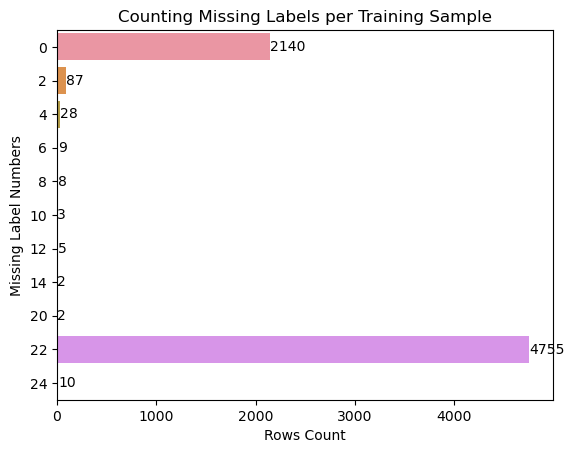

In [8]:
na_counts = coordinates.isna().sum(axis = 1).value_counts()
ax = sns.barplot(data = pd.DataFrame({"missing_col_numbers": na_counts.index.to_numpy(), "count": na_counts.to_numpy()}), 
            y = "missing_col_numbers", x = "count", orient = "h")
ax.set_ylabel("Missing Label Numbers")
ax.set_xlabel("Rows Count")
ax.set_title("Counting Missing Labels per Training Sample")
ax.bar_label(ax.containers[0], fontsize=10)
plt.show()

Utility function for image display.

In [9]:
def display_images(images, coordinates = None):
    n_images = len(images)
    nrow = math.ceil(n_images/5)
    ncol = 5
    fig, ax = plt.subplots(nrow, ncol, figsize = (ncol*2, nrow*2))
    for i in range(nrow):
        for j in range(ncol):
            idx = i * 5 + j
            if idx < n_images:
                if coordinates is not None:
                    coordinate = coordinates[idx]
                    x, y = [], []
                    for k in range(0, len(coordinate), 2):
                        if not np.isnan(coordinate[k]):
                            x += [coordinate[k]]
                            y += [coordinate[k+1]]
                ax[i, j].imshow(np.transpose(images[idx], axes=(1, 2, 0)), cmap="gray")
                if coordinates is not None:
                    ax[i, j].scatter(x, y, marker = ".", s = 10, color = "red")
                ax[i, j].set_xticks([])
                ax[i, j].set_yticks([])
    plt.tight_layout()
    plt.show()

### 2.5 Sample Images

We separate the images into two groups: with all facial keypoints and with missing values.

- Randomly pick 5 images from each group and display in the plot.
- Images from the first group appear to be more clear and well oriented.
- Images from the second group (with missing target values) look more blurry and have more diverse viewing angles.

In [10]:
idx_no_missing = coordinates.index[coordinates["has_missing_labels"] == False].tolist()
idx_with_missing = coordinates.index[coordinates["has_missing_labels"] == True].tolist()
images_no_missing, images_with_missing = images[idx_no_missing], images[idx_with_missing]
coordinates_no_missing, coordinates_with_missing = coordinates.iloc[idx_no_missing, :-1].to_numpy(), coordinates.iloc[idx_with_missing, :-1].to_numpy()

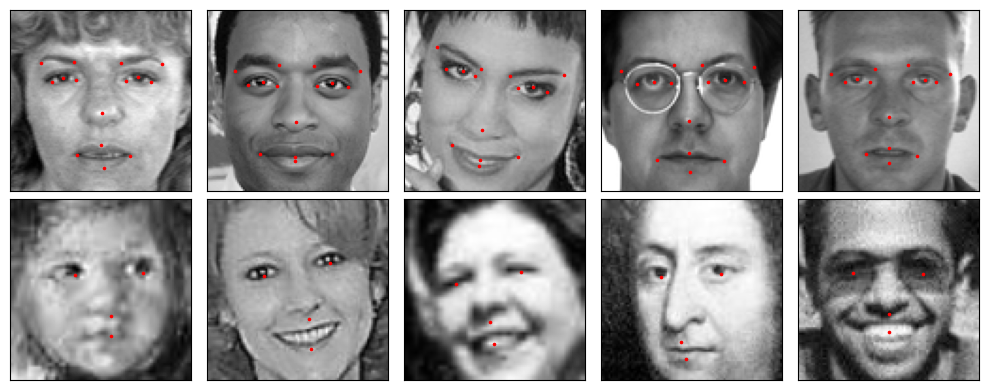

In [11]:
idx1 = random.sample(range(len(images_no_missing)), 5)
idx2 = random.sample(range(len(images_with_missing)), 5)
display_images(np.concatenate((images_no_missing[idx1], images_with_missing[idx2]), axis = 0), 
               np.concatenate((coordinates_no_missing[idx1], coordinates_with_missing[idx2]), axis = 0))

### 2.6 Approaches to the Problem

Since we need to align target values for learning regression model, here are our possible approaches:

- **<font color="blue">Drop all data with missing target values.</font>**
- **<font color="blue">Impute the missing target values. Two methods of imputation will be used:</font>**
    - **<font color="blue">Simple imputation (forward fill)</font>**
    - **<font color="blue">Imputation by semi-supervised learning</font>**
- **<font color="blue">Use multiple models (in this case two models), which means one model for predicting 15 facial keypoints and another for predicting 4 facial keypoints.</font>**

***

We do a simple <font color="blue">ffill</font> imputation and examine the imputed results. As expected, such a simple imputation strategy doesn't come up with good data quality (many of the facial keypoints are not properly located), but we will anyway train on this data as part of our way of finding optimal approach.

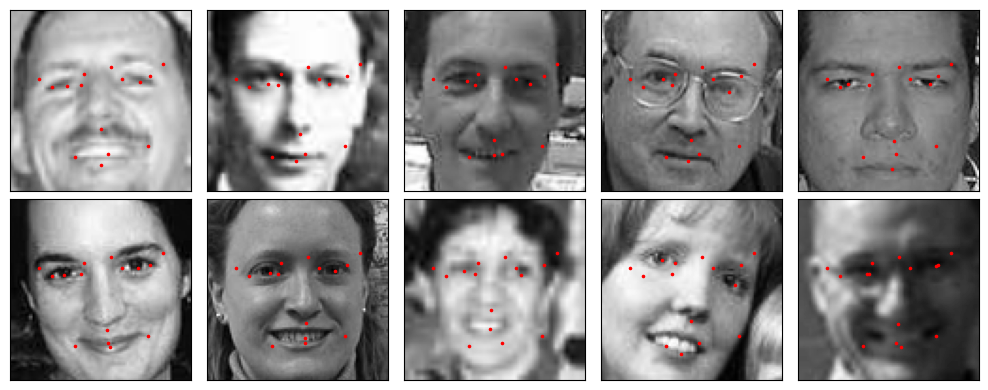

In [12]:
coordinates_imputed = coordinates.fillna(method = 'ffill').iloc[:, :-1].to_numpy()
idx = random.sample(idx_with_missing, 10)
display_images(images[idx], coordinates_imputed[idx])

## 3. Model Architecture and Model Training

### 3.1 Simple CNN

- Since CNN has already become the de facto method for solving computer vision problems, we only test CNN architectures in this study.
- We first use a simple CNN to test approaches listed in section 2.6, then use transfer learning, trying to futher improve the prediction, for the best one.
- We begin with a relatively simple model: **(CONV2d + ReLU + CONV2d + BatchNorm2d + ReLU + MaxPool2) x 2 + Dropout2d + (CONV2d + ReLU + CONV2d + BatchNorm2d + ReLU + Maxpool2d) + Linear**
- Model1 is used for all three approaches (drop-all-missing, imputation, and two-model) and has an output of 30 elements (matching the 15 facial keypoint coordiantes)
- Model2 is almost the same as Model1 except with a 8-element output (matching the 4 facial keypoint coordiantes). It is only used for the two-model approach.

In [13]:
class Model1(nn.Module):
    def __init__(self, img_size = 96):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size = 3, padding = 1)
        self.bnorm1 = nn.BatchNorm2d(64)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(64, 64, kernel_size = 3, padding = 1)
        self.bnorm2 = nn.BatchNorm2d(64)
        self.relu2 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size = 2)
        img_size = img_size // 2
        self.conv3 = nn.Conv2d(64, 128, kernel_size = 3, padding = 1)
        self.bnorm3 = nn.BatchNorm2d(128)
        self.relu3 = nn.ReLU()
        self.conv4 = nn.Conv2d(128, 128, kernel_size = 3, padding = 1)
        self.bnorm4 = nn.BatchNorm2d(128)
        self.relu4 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size = 2)
        self.dropout1 = nn.Dropout2d(0.3)
        img_size = img_size // 2
        self.conv5 = nn.Conv2d(128, 256, kernel_size = 3, padding = 1)
        self.bnorm5 = nn.BatchNorm2d(256)
        self.relu5 = nn.ReLU()
        self.conv6 = nn.Conv2d(256, 256, kernel_size = 3, padding = 1)
        self.bnorm6 = nn.BatchNorm2d(256)
        self.relu6 = nn.ReLU()
        self.maxpool3 = nn.MaxPool2d(kernel_size = 2)
        img_size = img_size // 2
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(256*img_size*img_size, 512)
        self.linear2 = nn.Linear(512, 30)
    
    def forward(self, x):
        x = self.maxpool1(self.relu2(self.bnorm2(self.conv2(self.relu1(self.bnorm1(self.conv1(x)))))))
        x = self.maxpool2(self.relu4(self.bnorm4(self.conv4(self.relu3(self.bnorm3(self.conv3(x)))))))
        x = self.dropout1(x)
        x = self.maxpool3(self.relu6(self.bnorm6(self.conv6(self.relu5(self.bnorm5(self.conv5(x)))))))
        x = self.flatten(x)
        x = self.linear1(x)
        x = self.linear2(x)
        return x

In [14]:
class Model2(nn.Module):
    def __init__(self, img_size = 96):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size = 3, padding = 1)
        self.bnorm1 = nn.BatchNorm2d(64)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(64, 64, kernel_size = 3, padding = 1)
        self.bnorm2 = nn.BatchNorm2d(64)
        self.relu2 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size = 2)
        img_size = img_size // 2
        self.conv3 = nn.Conv2d(64, 128, kernel_size = 3, padding = 1)
        self.bnorm3 = nn.BatchNorm2d(128)
        self.relu3 = nn.ReLU()
        self.conv4 = nn.Conv2d(128, 128, kernel_size = 3, padding = 1)
        self.bnorm4 = nn.BatchNorm2d(128)
        self.relu4 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size = 2)
        self.dropout1 = nn.Dropout2d(0.3)
        img_size = img_size // 2
        self.conv5 = nn.Conv2d(128, 256, kernel_size = 3, padding = 1)
        self.bnorm5 = nn.BatchNorm2d(256)
        self.relu5 = nn.ReLU()
        self.conv6 = nn.Conv2d(256, 256, kernel_size = 3, padding = 1)
        self.bnorm6 = nn.BatchNorm2d(256)
        self.relu6 = nn.ReLU()
        self.maxpool3 = nn.MaxPool2d(kernel_size = 2)
        img_size = img_size // 2
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(256*img_size*img_size, 512)
        self.linear2 = nn.Linear(512, 8)
    
    def forward(self, x):
        x = self.maxpool1(self.relu2(self.bnorm2(self.conv2(self.relu1(self.bnorm1(self.conv1(x)))))))
        x = self.maxpool2(self.relu4(self.bnorm4(self.conv4(self.relu3(self.bnorm3(self.conv3(x)))))))
        x = self.dropout1(x)
        x = self.maxpool3(self.relu6(self.bnorm6(self.conv6(self.relu5(self.bnorm5(self.conv5(x)))))))
        x = self.flatten(x)
        x = self.linear1(x)
        x = self.linear2(x)
        return x

### 3.2 Utility functions

***

Utility function for training and plotting results.

In [15]:
def train_model(model, dl_train, dl_val, optimizer, criterion = nn.MSELoss(), n_epochs = 10, verbose = True):
    start_time = datetime.datetime.now()
    training_loss, val_loss = [], []
    for epoch in range(1, n_epochs+1):
        tl, vl, = 0.0, 0.0

        for images, coordinates in dl_train:
            cur_batch_size = len(images)
            images, coordinates = images.to(device), coordinates.float().to(device)
            optimizer.zero_grad()
            outputs = model(images).squeeze()
            loss = criterion(outputs, coordinates)
            loss.backward()
            optimizer.step()
            tl += loss.item()
        
        if dl_val is not None:
            model.eval()
            with torch.no_grad():
                for images, coordinates in dl_val:
                    images, coordinates = images.to(device), coordinates.float().to(device)
                    outputs = model(images).squeeze()
                    loss = criterion(outputs, coordinates)
                    vl += loss.item()
            model.train()

        time, tl, vl = datetime.datetime.now(), tl / len(dl_train), (vl/len(dl_val) if dl_val is not None else vl)

        training_loss.append(tl)
        val_loss.append(vl)
        
        if verbose and epoch % (n_epochs // 10) == 0:
            fmt_str = '{} Epoch {}, Training loss {:.4f}, Validation loss {:.4f}'
            print(fmt_str.format(datetime.datetime.now(), epoch, tl, vl))
    
    training_time = datetime.datetime.now() - start_time
    return training_loss, val_loss, training_time

In [16]:
def plot_loss_and_acc(training_loss, val_loss, offset = 0):
    fig, ax = plt.subplots(1, 1, figsize = (8, 6))
    ax.plot(range(offset+1, len(training_loss)+1), training_loss[offset:], '-', linewidth=0.5, label="training")
    ax.plot(range(offset+1, len(val_loss)+1), val_loss[offset:], '-', linewidth=0.5, label="validation")
    ax.legend()
    ax.set_xlabel("epoch")
    ax.set_ylabel("loss / MSE")

Utility function of model parameter initialization.

In [17]:
def weights_init(m):
    if isinstance(m, nn.Conv2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)

Utility function of test image prediction. It has two versions, one for single-model approach and another for two-model approach. The output format is according to the lookup table in the provided data.

In [18]:
def compute_test_outputs(model, images = None, masked = False):
    if images is None:
        dataset_test = TensorDataset(torch.from_numpy(images_test).float())
    else:
        dataset_test = TensorDataset(torch.from_numpy(images).float())
    dataloader_test = DataLoader(dataset_test, shuffle = False, batch_size = batch_size)
    test_outputs = None
    model.eval()
    with torch.no_grad():
        for images in dataloader_test:
            images = images[0].to(device)
            outputs = model(images).squeeze()
            if test_outputs is None:
                test_outputs = outputs
            else:
                if len(outputs.shape) == 1:
                    outputs = outputs.view(1, -1)
                test_outputs = torch.concatenate((test_outputs, outputs), 0)
    model.train()
    test_outputs = test_outputs.cpu().numpy()
    if masked:
        temp = np.ones_like(test_outputs) * np.nan
        for i in range(len(df_lookup)):
            rowId = df_lookup.iloc[i]["ImageId"] - 1
            temp[rowId][feature_lookup[df_lookup.iloc[i]["FeatureName"]]] = test_outputs[rowId][feature_lookup[df_lookup.iloc[i]["FeatureName"]]]
        test_outputs = temp
    return test_outputs

In [19]:
def compute_test_outputs2(model1, model2, dataset):
    dataloader_test = DataLoader(dataset, shuffle = False, batch_size = batch_size)
    test_outputs1, test_outputs2 = None, None
    model1.eval()
    model2.eval()
    with torch.no_grad():
        for images in dataloader_test:
            images = images[0].to(device)
            outputs1 = model1(images).squeeze()
            outputs2 = model2(images).squeeze()
            if test_outputs1 is None or test_outputs2 is None:
                test_outputs1 = outputs1
                test_outputs2 = outputs2
            else:
                if len(outputs1.shape) == 1:
                    outputs1 = outputs1.view(1, -1)
                if len(outputs2.shape) == 1:
                    outputs2 = outputs2.view(1, -1)
                test_outputs1 = torch.concatenate((test_outputs1, outputs1), 0)
                test_outputs2 = torch.concatenate((test_outputs2, outputs2), 0)
    model1.train()
    model2.train()
    test_outputs1 = test_outputs1.cpu().numpy()
    test_outputs2 = test_outputs2.cpu().numpy()
    temp = np.ones_like(test_outputs1) * np.nan
    lookup_feature_count = df_lookup.groupby(["ImageId"]).count()
    index_set1 = set((lookup_feature_count[lookup_feature_count["FeatureName"] > 8].index - 1).tolist())
    index_set2 = set((lookup_feature_count[lookup_feature_count["FeatureName"] <= 8].index - 1).tolist())
    for i in range(len(df_lookup)):
        rowId = df_lookup.iloc[i]["ImageId"] - 1
        if rowId in index_set1:
            temp[rowId][feature_lookup[df_lookup.iloc[i]["FeatureName"]]] = test_outputs1[rowId][feature_lookup[df_lookup.iloc[i]["FeatureName"]]]
        else:
            temp[rowId][feature_lookup[df_lookup.iloc[i]["FeatureName"]]] = test_outputs2[rowId][feature_lookup_set2[df_lookup.iloc[i]["FeatureName"]]]
    return temp

Utility function of creating Kaggle submission file.

In [20]:
def create_submission(test_outputs, file_name = "submission.csv"):
    location = []
    for i in range(len(df_lookup)):
        imageId, featureName = df_lookup.iloc[i]["ImageId"], df_lookup.iloc[i]["FeatureName"]
        location += [test_outputs[imageId-1][feature_lookup[featureName]]]
    pd.DataFrame({"RowId": df_lookup["RowId"].tolist(), "Location": location}).to_csv(file_name, index = False)

### 3.3 Drop-all-missing with Simple CNN

- We only train on 2,140 images which are provided with all 15 facial keypoints. 
- The training curve looks alright except with a high fluctuated validation loss due to relatively small dataset.
- The prediction quality is not good, especially in the case of predicting images with 4 or lower facial keypoints. This is expected since this group of data is not included in the training.
- The Kaggle score of this model is: <font color="red">3.36156 (Public Score)</font>

In [21]:
images_no_missing_train, images_no_missing_val, coordinates_no_missing_train, coordinates_no_missing_val = \
    train_test_split(images_no_missing, coordinates_no_missing, train_size = 0.8, random_state = 1301)
images_inputed_train, images_inputed_val, coordinates_imputed_train, coordinates_imputed_val = \
    train_test_split(images, coordinates_imputed, train_size = 0.8, random_state = 1301, stratify = has_missing_labels)

In [22]:
n_epochs, lr, batch_size = 400, 1e-4, 32

dataset_train = TensorDataset(torch.from_numpy(images_no_missing_train).float(), torch.from_numpy(coordinates_no_missing_train).float())
dataset_val = TensorDataset(torch.from_numpy(images_no_missing_val).float(), torch.from_numpy(coordinates_no_missing_val).float())
g = torch.Generator()
g.manual_seed(0)
dataloader_train = DataLoader(dataset_val, shuffle = True, batch_size = batch_size, generator = g)
dataloader_val = DataLoader(dataset_val, shuffle = True, batch_size = batch_size, generator = g)

model_no_missing = Model1()
weights_init(model_no_missing)
model_no_missing.to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model_no_missing.parameters(), lr=lr)

training_loss, val_loss, training_time = train_model(model_no_missing, dataloader_train, dataloader_val, optimizer, criterion, n_epochs)

2023-10-16 16:02:58.787027 Epoch 40, Training loss 1.9789, Validation loss 1.6819
2023-10-16 16:03:18.723131 Epoch 80, Training loss 0.8082, Validation loss 0.6246
2023-10-16 16:03:37.871410 Epoch 120, Training loss 0.5678, Validation loss 0.3119
2023-10-16 16:03:56.603769 Epoch 160, Training loss 0.3054, Validation loss 0.3623
2023-10-16 16:04:16.001313 Epoch 200, Training loss 0.2523, Validation loss 0.2590
2023-10-16 16:04:35.882258 Epoch 240, Training loss 0.2226, Validation loss 0.1485
2023-10-16 16:04:55.120236 Epoch 280, Training loss 0.3997, Validation loss 0.2244
2023-10-16 16:05:14.552384 Epoch 320, Training loss 0.3677, Validation loss 0.2212
2023-10-16 16:05:33.802748 Epoch 360, Training loss 0.1604, Validation loss 0.5828
2023-10-16 16:05:53.144125 Epoch 400, Training loss 0.3246, Validation loss 1.1573


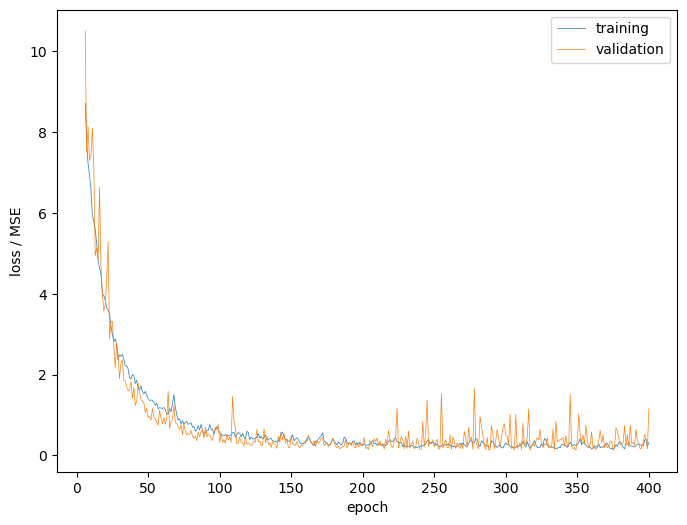

In [23]:
plot_loss_and_acc(training_loss, val_loss, 5)

<font color="blue">Test samples by drop-all-missing with simple CNN:</font>

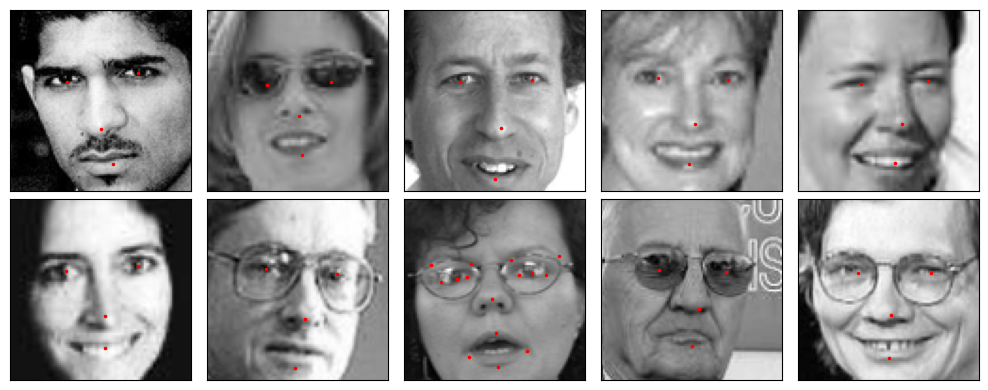

In [24]:
test_outputs = compute_test_outputs(model_no_missing, masked = True)
idx = random.sample(range(len(images_test)), 10)
display_images(images_test[idx], test_outputs[idx])

Preparing for Kaggle submission:

In [25]:
create_submission(test_outputs, file_name = "no_missing_final.csv")

### 3.4 Simple imputation (forward fill) with Simple CNN

- We train on all 7,049 images. Missing target values are imputed by simple forward fill method.
- As we can see from the previous section, the imputation is not accurate and many of the imputed facial keypoints are off-target.
- Images with and without missing target values show different characteristics (likely coming from different distributions and hence increasing the heterogeneity of the dataset), so we can observe more fluctuation in the training curve (especially the validation loss).
- The effect of this imputation is mixed. More training data (with right target values) improves prediction, but the inaccuracy of the imputed values introduces inteference. The final result shows that the former outruns the latter. The Kaggle score of this model improves to: <font color="red">2.84426 (Public Score)</font>

In [26]:
n_epochs, lr, batch_size = 400, 1e-4, 32

dataset_train = TensorDataset(torch.from_numpy(images_inputed_train).float(), torch.from_numpy(coordinates_imputed_train).float())
dataset_val = TensorDataset(torch.from_numpy(images_inputed_val).float(), torch.from_numpy(coordinates_imputed_val).float())
g = torch.Generator()
g.manual_seed(0)
dataloader_train = DataLoader(dataset_val, shuffle = True, batch_size = batch_size, generator = g)
dataloader_val = DataLoader(dataset_val, shuffle = True, batch_size = batch_size, generator = g)

model_imputed = Model1()
weights_init(model_imputed)
model_imputed.to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model_imputed.parameters(), lr=lr)

training_loss, val_loss, training_time = train_model(model_imputed, dataloader_train, dataloader_val, optimizer, criterion, n_epochs)

2023-10-16 16:07:05.059815 Epoch 40, Training loss 2.4591, Validation loss 2.1740
2023-10-16 16:08:08.486852 Epoch 80, Training loss 0.9093, Validation loss 1.7626
2023-10-16 16:09:12.773793 Epoch 120, Training loss 0.6005, Validation loss 0.7284
2023-10-16 16:10:16.467744 Epoch 160, Training loss 0.5857, Validation loss 0.9595
2023-10-16 16:11:19.771210 Epoch 200, Training loss 0.3773, Validation loss 0.5404
2023-10-16 16:12:22.797543 Epoch 240, Training loss 0.3440, Validation loss 0.4246
2023-10-16 16:13:26.023998 Epoch 280, Training loss 0.2447, Validation loss 0.3470
2023-10-16 16:14:29.206141 Epoch 320, Training loss 0.2844, Validation loss 0.2556
2023-10-16 16:15:32.664283 Epoch 360, Training loss 0.2058, Validation loss 0.3261
2023-10-16 16:16:36.000409 Epoch 400, Training loss 0.2081, Validation loss 0.9853


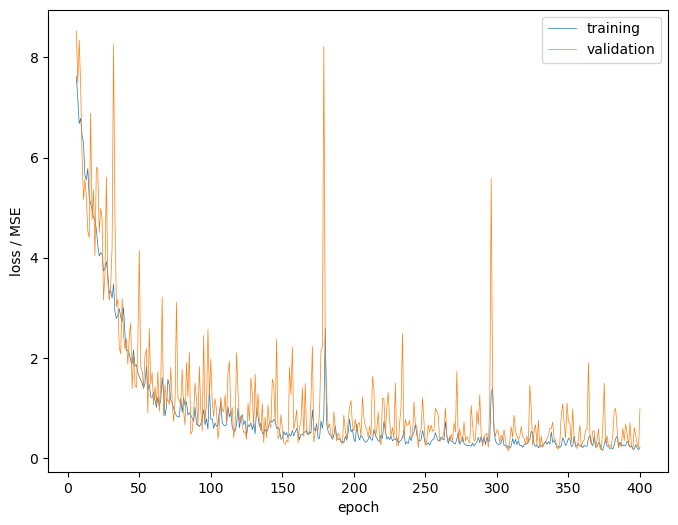

In [27]:
plot_loss_and_acc(training_loss, val_loss, offset = 5)

<font color="blue">Test samples by simple imputation (forward fill) with simple CNN:</font>

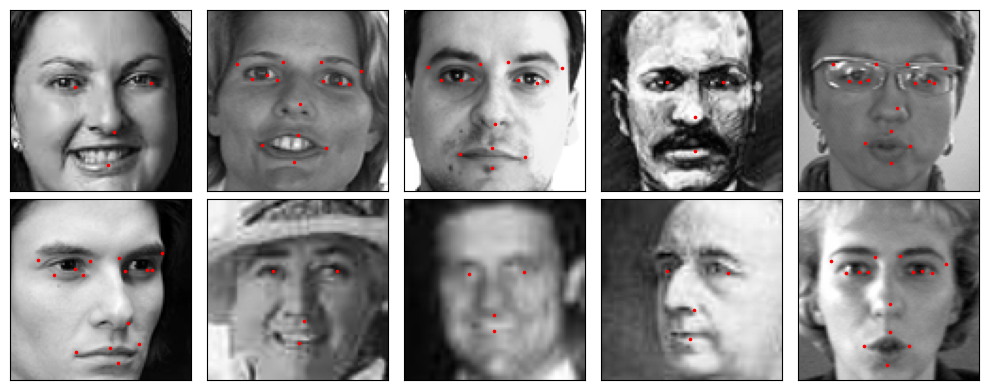

In [28]:
test_outputs = compute_test_outputs(model_imputed, masked = True)
idx = random.sample(range(len(images_test)), 10)
display_images(images_test[idx], test_outputs[idx])

Preparing for Kaggle submission:

In [29]:
create_submission(test_outputs, file_name = "inputed_final.csv")

### 3.5 Imputation by Semi-supervised Learning with Simple CNN

Semi-supervised learning is usually applied in situations where it's difficult to collect a large volume of labeled data. For example, in medical image analysis, gathering labeled medical images may require the expertise of specialists, making it a resource-intensive task. In current study, the goal is to predict or impute missing values in the dataset, and the procedure is as follows:

 - Model is trained on labeled/pseudo-labeled data (without missing values).
 - The trained model predicts on partially labeled data (with missing values).
 - <font color="red">Choose top 10% of the predicted values with the lowest MSE loss.</font>
 - Combining the predicted values with partially labeled data (We only use predictions for the missing values. The given target values are intact).
 - Merge the result from the previous step with the original labeled/pseudo-labeled data and repeat these steps 10 times until all missing values are imputed.

Semi-supervised imputation can improve the imputation accuracy compared to simple methods. It takes into account the relationships between features and target values learned from labeled data, making it a more data-driven approach.

***

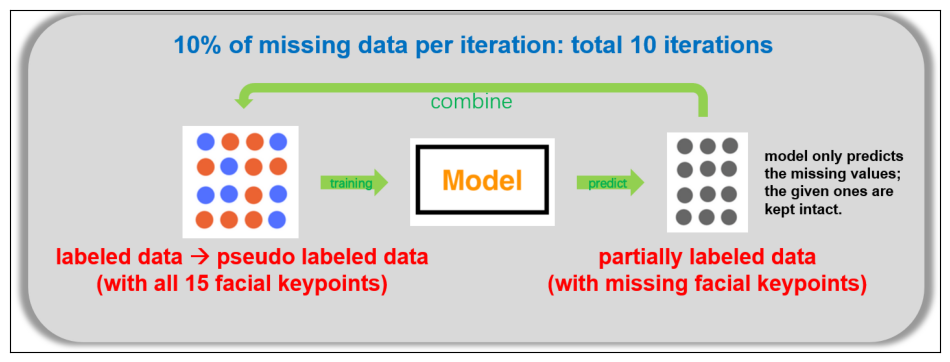

In [54]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
ax.imshow(cv2.cvtColor(cv2.imread("images/semi_supervised.png"), cv2.COLOR_BGR2RGB))
ax.set_xticks([])
ax.set_yticks([])
plt.show()

***

- It can be observed that the imputation is more accurate in the first few iterations (with lower MSE loss) and becoming more inaccurate as the iterations go on.
- Nevertheless, it is still a better method than simple imputations like forward fill used in the last section. The Kaggle score of this model improves marginally to: <font color="red">2.81488 (Public Score)</font>


Iteration 1:


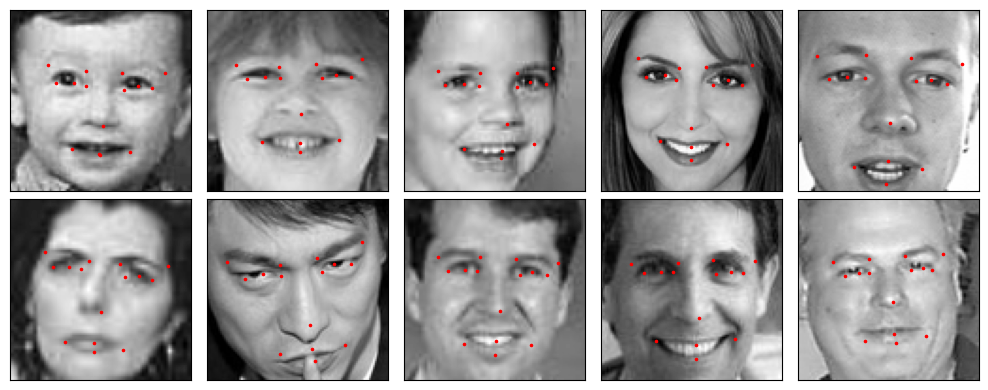


Iteration 5:


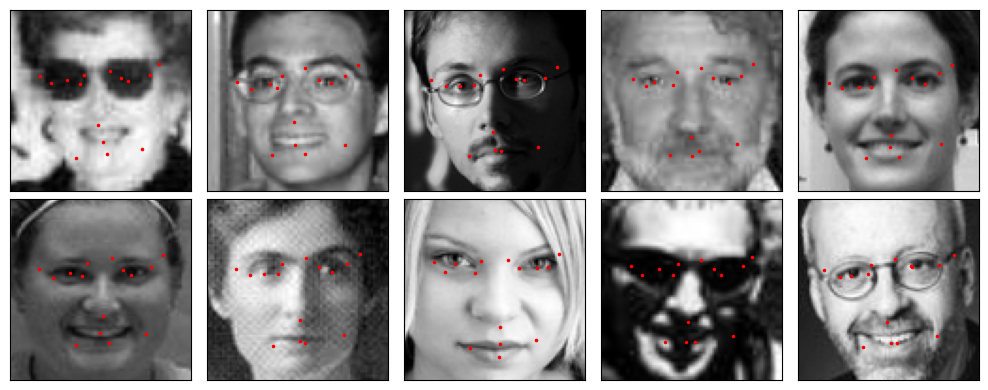


Iteration 10:


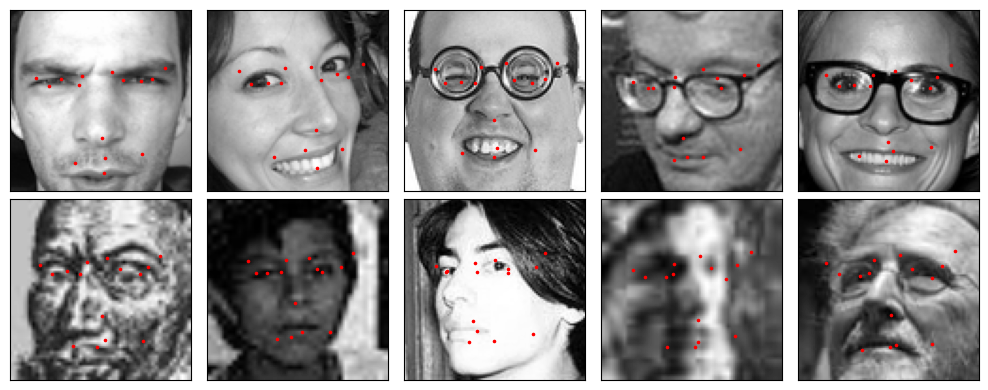

In [30]:
images_pseudo_labeled, images_no_label, coordinates_pseudo_labeled, coordinates_no_label =\
    np.copy(images_no_missing), np.copy(images_with_missing), np.copy(coordinates_no_missing), np.copy(coordinates_with_missing)

model_pseudo_labeled = model_no_missing

num_iteration = 10
pseudo_labels_per_iteration = math.ceil(len(images_no_label)/num_iteration)

for i in range(1, num_iteration+1):
    coordinates_no_label_predicted = compute_test_outputs(model_pseudo_labeled, images_no_label)
    mse = np.nanmean((coordinates_no_label_predicted - coordinates_no_label)**2, axis = 1)
    if len(mse) >= pseudo_labels_per_iteration:
        idx = np.argsort(mse)[:pseudo_labels_per_iteration]
    else:
        idx = np.arange(len(mse))

    if i%5 == 0 or i == 1:
        print("")
        print("Iteration " + str(i) + ":")
        display_images(np.concatenate((images_no_label[idx][:5], images_no_label[idx][-5:]), axis = 0), 
                       np.concatenate((coordinates_no_label_predicted[idx][:5], coordinates_no_label_predicted[idx][-5:]), axis = 0))
    images_pseudo_labeled = np.concatenate((images_pseudo_labeled, images_no_label[idx]), axis = 0)
    images_no_label = np.delete(images_no_label, idx, axis = 0)
    temp1 = np.copy(coordinates_no_label_predicted[idx])
    temp2 = np.copy(coordinates_no_label[idx])
    temp1[~np.isnan(temp2)] = 0
    temp2[np.isnan(temp2)] = 0
    coordinates_pseudo_labeled = np.concatenate((coordinates_pseudo_labeled, temp1+temp2), axis = 0)
    coordinates_no_label = np.delete(coordinates_no_label, idx, axis = 0)
    
    if len(images_no_label) > 0:
        n_epochs, lr, batch_size = 400, 1e-4, 32

        dataset_train = TensorDataset(torch.from_numpy(images_pseudo_labeled).float(), torch.from_numpy(coordinates_pseudo_labeled).float())
        g = torch.Generator()
        g.manual_seed(0)
        dataloader_train = DataLoader(dataset_val, shuffle = True, batch_size = batch_size, generator = g)

        model_pseudo_labeled = Model1()
        weights_init(model_pseudo_labeled)
        model_pseudo_labeled.to(device)
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model_pseudo_labeled.parameters(), lr=lr)

        _, _, _ =  train_model(model_pseudo_labeled, dataloader_train, None, optimizer, criterion, n_epochs = n_epochs, verbose = False)
    

In [31]:
images_pseudo_labeled_train, images_pseudo_labeled_val, coordinates_pseudo_labeled_train, coordinates_pseudo_labeled_val = \
    train_test_split(images_pseudo_labeled, coordinates_pseudo_labeled, train_size = 0.8, random_state = 1301)

In [32]:
n_epochs, lr, batch_size = 400, 1e-5, 32

dataset_train = TensorDataset(torch.from_numpy(images_pseudo_labeled_train).float(), torch.from_numpy(coordinates_pseudo_labeled_train).float())
dataset_val = TensorDataset(torch.from_numpy(images_pseudo_labeled_val).float(), torch.from_numpy(coordinates_pseudo_labeled_val).float())
g = torch.Generator()
g.manual_seed(0)
dataloader_train = DataLoader(dataset_val, shuffle = True, batch_size = batch_size, generator = g)
dataloader_val = DataLoader(dataset_val, shuffle = True, batch_size = batch_size, generator = g)

model_pseudo_labeled = Model1()
weights_init(model_pseudo_labeled)
model_pseudo_labeled.to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model_pseudo_labeled.parameters(), lr=lr)

training_loss, val_loss, training_time = train_model(model_pseudo_labeled, dataloader_train, dataloader_val, optimizer, criterion, n_epochs, verbose = False)

<font color="blue">Test samples by semi-supervised learning with simple CNN:</font>

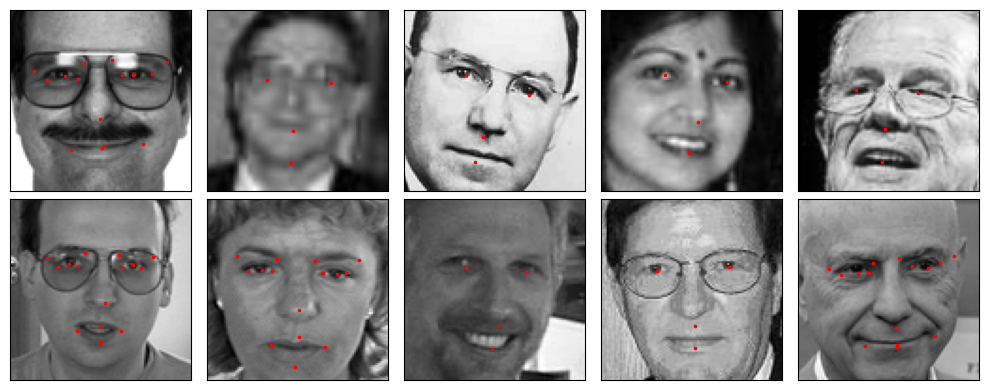

In [33]:
test_outputs = compute_test_outputs(model_pseudo_labeled, masked = True)
idx = random.sample(range(len(images_test)), 10)
display_images(images_test[idx], test_outputs[idx])

Preparing for Kaggle submission:

In [34]:
create_submission(test_outputs, file_name = "pseudo_labeled_final.csv")

### 3.6 Two-Model with Simple CNN

In machine learning, the term "multiple models" typically refers to an approach where multiple individual models, often of the same type or from different classes, are trained and used in combination to solve a specific task. This approach is used for a variety of purposes, including improving prediction accuracy, increasing robustness, handling complex tasks, and addressing issues like overfitting. In this study, we employ two separate models in training and prediction.

- <font color="blue">Grouping data into two sets: set1 of 2,140 images with all 15 facial keypoints; set2 of 4,755 images will 4 facial keypoints; the remaining 154 images are discarded.</font>
- <font color="blue">Train two separate models on dataset1 and dataset2 independently.</font>
- <font color="blue">When predictions require more than 4 facial keypoints, use model trained on dataset1.</font>
- <font color="blue">When predictions require less or equal than 4 facial keypoints, use model trained on dataset2.</font>
- It seems that multiple models approach is the right direction for this problem. The prediction quality further improves and the Kaggle score of this model is: <font color="red">2.5396 (Public Score)</font>

In [35]:
images_set1 = images[coordinates.isna().sum(axis = 1).apply(lambda x: x==0)]
coordinates_set1 = coordinates[coordinates.isna().sum(axis = 1).apply(lambda x: x==0)].iloc[:, :-1].to_numpy()
images_set2 = images[coordinates.isna().sum(axis = 1).apply(lambda x: x==22)]
coordinates_set2 = coordinates[coordinates.isna().sum(axis = 1).apply(lambda x: x==22)].iloc[:, :-1]
coordinates_set2 = coordinates_set2.drop(coordinates.columns[(coordinates[coordinates.isna().sum(axis = 1).apply(lambda x: x==22)].iloc[:].isna().sum(axis = 0) > 0)].tolist(), axis = 1)
coordinates_set2 = coordinates[coordinates.isna().sum(axis = 1).apply(lambda x: x==22)].iloc[:, :-1]
coordinates_set2 = coordinates_set2.drop(coordinates.columns[(coordinates[coordinates.isna().sum(axis = 1).apply(lambda x: x==22)].iloc[:].isna().sum(axis = 0) > 0)].tolist(), axis = 1)
feature_names_set2 = coordinates_set2.columns.tolist()
feature_lookup_set2 = {name: i for i, name in enumerate(feature_names_set2)}
coordinates_set2 = coordinates_set2.to_numpy()

In [36]:
images_set1_train, images_set1_val, coordinates_set1_train, coordinates_set1_val = \
    train_test_split(images_set1, coordinates_set1, train_size = 0.8, random_state = 1301)
images_set2_train, images_set2_val, coordinates_set2_train, coordinates_set2_val = \
    train_test_split(images_set2, coordinates_set2, train_size = 0.8, random_state = 1301)

In [37]:
n_epochs, lr, batch_size = 200, 1e-4, 32

dataset_train = TensorDataset(torch.from_numpy(images_set1_train).float(), torch.from_numpy(coordinates_set1_train).float())
dataset_val = TensorDataset(torch.from_numpy(images_set1_val).float(), torch.from_numpy(coordinates_set1_val).float())
g = torch.Generator()
g.manual_seed(0)
dataloader_train = DataLoader(dataset_val, shuffle = True, batch_size = batch_size, generator = g)
dataloader_val = DataLoader(dataset_val, shuffle = True, batch_size = batch_size, generator = g)

model_set1 = Model1()
weights_init(model_set1)
model_set1.to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model_set1.parameters(), lr=lr)

training_loss, val_loss, training_time = train_model(model_set1, dataloader_train, dataloader_val, optimizer, criterion, n_epochs, verbose = False)

In [38]:
n_epochs, lr, batch_size = 400, 1e-4, 32

dataset_train = TensorDataset(torch.from_numpy(images_set2_train).float(), torch.from_numpy(coordinates_set2_train).float())
dataset_val = TensorDataset(torch.from_numpy(images_set2_val).float(), torch.from_numpy(coordinates_set2_val).float())
g = torch.Generator()
g.manual_seed(0)
dataloader_train = DataLoader(dataset_val, shuffle = True, batch_size = batch_size, generator = g)
dataloader_val = DataLoader(dataset_val, shuffle = True, batch_size = batch_size, generator = g)

model_set2 = Model2()
weights_init(model_set2)
model_set2.to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model_set2.parameters(), lr=lr)

training_loss, val_loss, training_time = train_model(model_set2, dataloader_train, dataloader_val, optimizer, criterion, n_epochs, verbose = False)

<font color="blue">Test samples by two-model with simple CNN:</font>

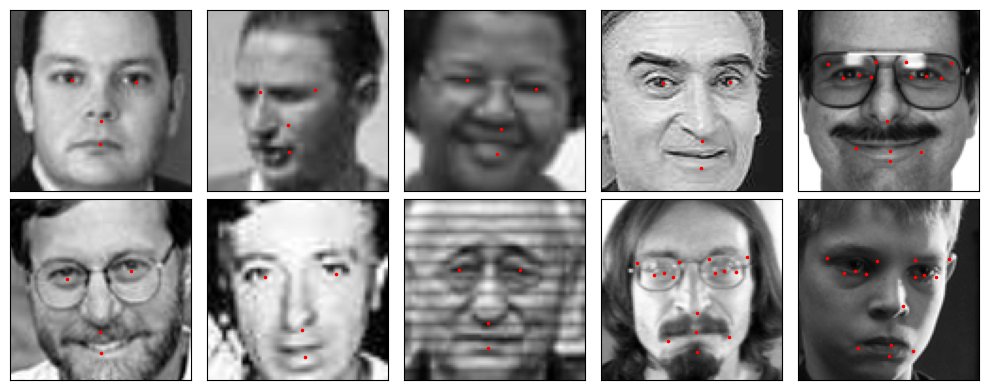

In [39]:
test_outputs = compute_test_outputs2(model_set1, model_set2, TensorDataset(torch.from_numpy(images_test).float()))
idx = random.sample(range(len(images_test)), 10)
display_images(images_test[idx], test_outputs[idx])

Preparing for Kaggle submission:

In [40]:
create_submission(test_outputs, file_name = "2models_final.csv")

### 3.7 Two-Model with Pretrained Network (EfficientNet-B0)

EfficientNet was introduced in 2019 by Google and became a popular architecture for many computer vision tasks. One of the strenths of EfficientNet is its ability to balance two usually contradicted goals in deep learning: computational efficiency and model performance. By systematically scaling the model's dimensions in a principled manner, EfficientNet achieves high levels of efficiency without compromising accuracy. Details about EfficientNet can be found in <a href="https://arxiv.org/pdf/1905.11946.pdf">here</a>. Torchvision library comes with pretrained EfficientNet, and we use the simplest version EfficientNet-B0 as our pretrained model.

- Images rescale to 224x224x3 to fit the EfficientNet-B0 model. Since our training image is gray scale, we simply replicate one-channel image into three-channel image.
- Although we use pretrained model, number of parameters in the model is much larger than our previous simple CNN and it still requires significant time of fine tuning the model.
- <font color="red">The prediction quality shows a huge improvement. Kaggle score of this model is: 1.92869 (Public Score)</font>

In [41]:
def get_eb0_model(output_dim):
    eb0_model = torchvision.models.efficientnet_b0(weights = EfficientNet_B0_Weights.DEFAULT)
    eb0_model.classifier[1] = nn.Linear(in_features=1280, out_features = output_dim)
    for params in eb0_model.parameters():
        params.requires_grad = True    
    return eb0_model

def get_train_transform(IMAGE_SIZE = 224):
    train_transform = transforms.Compose([
        transforms.Lambda(lambda x: x.repeat(3,1,1)),
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE), antialias = True),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    return train_transform

def get_val_transform(IMAGE_SIZE = 224):
    valid_transform = transforms.Compose([
        transforms.Lambda(lambda x: x.repeat(3,1,1)),
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE), antialias = True),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    return valid_transform

class EB0Dataset(Dataset):
    def __init__(self, data, target, transform):
        self.data = data
        self.target = target
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        x = self.transform(self.data[index])
        y = self.target[index]
        return x, y

In [42]:
n_epochs, lr, batch_size = 200, 3e-3, 32

dataset_train = EB0Dataset(torch.from_numpy(images_set1_train).float(), torch.from_numpy(coordinates_set1_train).float(), get_train_transform())
dataset_val = EB0Dataset(torch.from_numpy(images_set1_val).float(), torch.from_numpy(coordinates_set1_val).float(), get_train_transform())
g = torch.Generator()
g.manual_seed(0)
dataloader_train = DataLoader(dataset_train, shuffle = True, batch_size = batch_size, generator = g)
dataloader_val = DataLoader(dataset_val, shuffle = True, batch_size = batch_size, generator = g)

model_set1 = get_eb0_model(30)
model_set1.to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model_set1.parameters(), lr=lr)

training_loss, val_loss, training_time = train_model(model_set1, dataloader_train, dataloader_val, optimizer, criterion, n_epochs, verbose = False)

In [43]:
n_epochs, lr, batch_size = 400, 3e-3, 32

dataset_train = EB0Dataset(torch.from_numpy(images_set2_train).float(), torch.from_numpy(coordinates_set2_train).float(), get_train_transform())
dataset_val = EB0Dataset(torch.from_numpy(images_set2_val).float(), torch.from_numpy(coordinates_set2_val).float(), get_train_transform())
g = torch.Generator()
g.manual_seed(0)
dataloader_train = DataLoader(dataset_train, shuffle = True, batch_size = batch_size, generator = g)
dataloader_val = DataLoader(dataset_val, shuffle = True, batch_size = batch_size, generator = g)

model_set2 = get_eb0_model(8)
model_set2.to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model_set2.parameters(), lr=lr)

training_loss, val_loss, training_time = train_model(model_set2, dataloader_train, dataloader_val, optimizer, criterion, n_epochs, verbose = False)

Preparing for Kaggle submission:

In [44]:
test_outputs = compute_test_outputs2(model_set1, model_set2, EB0Dataset(torch.from_numpy(images_test).float(), torch.from_numpy(images_test).float(), get_val_transform()))
create_submission(test_outputs, file_name = "2eb0_final.csv")

### 3.8 Hyperparameter Tuning

Since we've reached our optimal approach and architecture, we train the model with all data (no left-out for validation) and try out a small range hyperparameter tuning. Directions:
- Effect of different learning rates
- Effect of different momentum parameters $\beta_1$

In [45]:
result_set = []
parameter_set = [
        {"lr": 3e-3, "beta_1": 0.5},
        {"lr": 1e-3, "beta_1": 0.5},
        {"lr": 3e-3, "beta_1": 0.9},
        {"lr": 1e-3, "beta_1": 0.9}
]

In [46]:
for param in parameter_set:
    n_epochs, batch_size = 200, 32
    lr, beta_1 = param["lr"], param["beta_1"]

    criterion = nn.MSELoss()
    model_set1 = get_eb0_model(30)
    model_set1.to(device)
    optimizer = optim.Adam(model_set1.parameters(), lr=lr, betas=(beta_1, 0.999))

    dataset_train = EB0Dataset(torch.from_numpy(images_set1).float(), torch.from_numpy(coordinates_set1).float(), get_train_transform())
    g = torch.Generator()
    g.manual_seed(0)
    dataloader_train = DataLoader(dataset_train, shuffle = True, batch_size = batch_size, generator = g)

    _, _, training_time1 = train_model(model_set1, dataloader_train, None, optimizer, criterion, n_epochs, verbose = False)    

    n_epochs = 400
    criterion = nn.MSELoss()
    model_set2 = get_eb0_model(8)
    model_set2.to(device)
    optimizer = optim.Adam(model_set2.parameters(), lr=lr, betas=(beta_1, 0.999))

    dataset_train = EB0Dataset(torch.from_numpy(images_set2).float(), torch.from_numpy(coordinates_set2).float(), get_train_transform())
    g = torch.Generator()
    g.manual_seed(0)
    dataloader_train = DataLoader(dataset_train, shuffle = True, batch_size = batch_size, generator = g)

    _, _, training_time2 = train_model(model_set2, dataloader_train, None, optimizer, criterion, n_epochs, verbose = False)    


    result_set.append({"model_set1": model_set1, "model_set2": model_set2, "training_time": training_time1+training_time2})

## 4. Results and Analysis

### 4.1 Results Summary

The following table summarizes and compares the training results of the parameter set:

- We've tried to include batch_size as one of the hyperparameters. However, increasing batch size will cause GPU memory overflow so we don't do test on this.
- In this study, validation loss does not work as a good indicator for final performance, so we rely on the Kaggle's score as our model comparison criterion and test case 3 (lr = 1e-3 and $\beta_1$ = 0.9) achieve the best result. <font color="red">This result could rank top 5 in the leaderboard (1.85692).</font>
- Learning rate has a greater effect on training performance, it seems that we can test higher values but due to time constraint we don't elaborate this direction further.
- Training performance prefers larger $\beta_1$ in our test. $\beta_1=0.9$ is the default value of the Adam optimizer and it works fine.
- EfficientNet-B0 is a complex model and it takes more than 1.5 hours for only fine tuning (two models).

In [47]:
test_cases = pd.DataFrame(parameter_set)
training_time = []
for result in result_set:
    training_time.append(result["training_time"].seconds)

test_cases["training_time (s)"] = training_time
test_cases["test score (public)"] = [1.89665, 1.89621, 1.91492, 1.85692]

test_cases

lr  beta_1  training_time (s)  test score (public)
0  0.003     0.5               5688              1.89665
1  0.001     0.5               5661              1.89621
2  0.003     0.9               5635              1.91492
3  0.001     0.9               5565              1.85692

### 4.2 Showcase Results of the Optimal Model

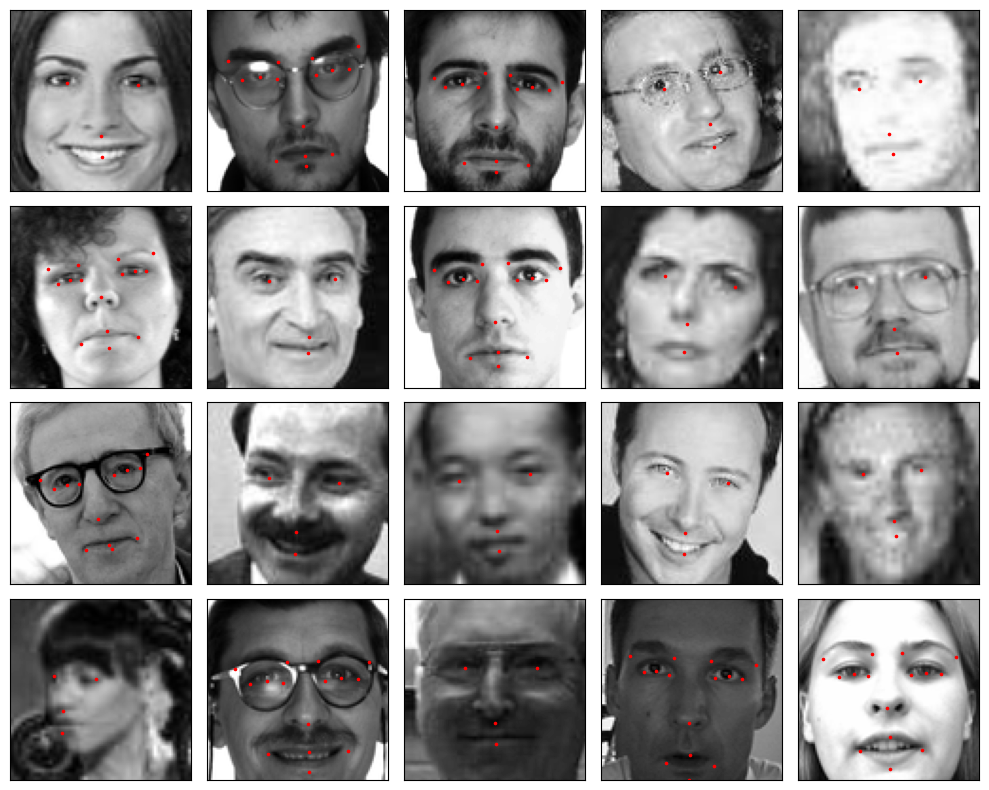

In [48]:
test_outputs = compute_test_outputs2(result_set[3]["model_set1"], result_set[3]["model_set2"], EB0Dataset(torch.from_numpy(images_test).float(), torch.from_numpy(images_test).float(), get_val_transform()))
idx = random.sample(range(len(images_test)), 20)
display_images(images_test[idx], test_outputs[idx])

Preparing for Kaggle submission:

In [49]:
for i in range(len(result_set)):
    model_set1 = result_set[i]["model_set1"]
    model_set2 = result_set[i]["model_set2"]
    test_outputs = compute_test_outputs2(model_set1, model_set2, EB0Dataset(torch.from_numpy(images_test).float(), torch.from_numpy(images_test).float(), get_val_transform()))
    create_submission(test_outputs, file_name = "test_case" + str(i) + "_final.csv")

### 4.3 Kaggle Results

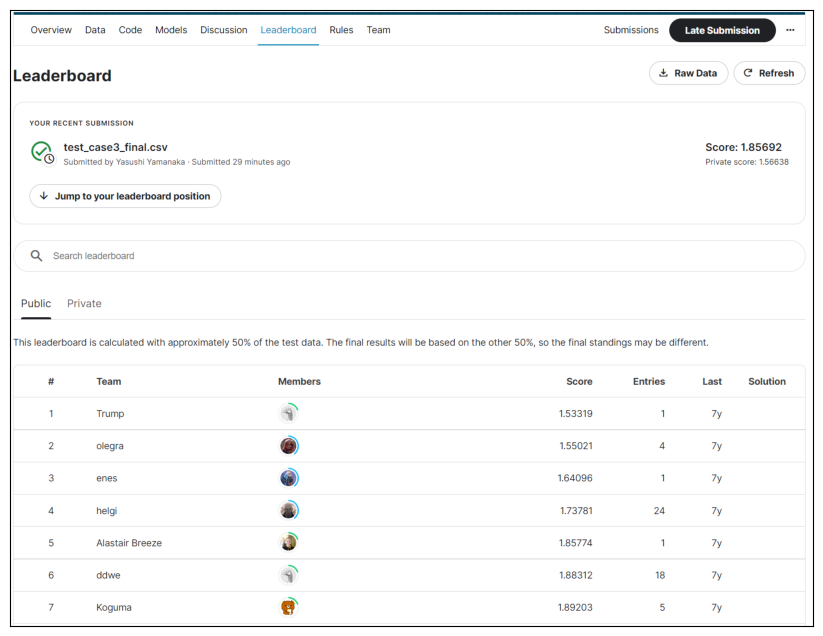

In [52]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
ax.imshow(cv2.cvtColor(cv2.imread("images/kaggle_results.png"), cv2.COLOR_BGR2RGB))
ax.set_xticks([])
ax.set_yticks([])
plt.show()

## 5. Discussion and Conclusion

### 5.1 Learning and Takeaways
- In this study, we employ CNN for solving regression problem of facial keypoints detection. We use self-built CNN and pretrained CNN (EfficientNet-B0) models. Regarding to heterogeneity of the dataset, we apply four different approach to tackle this issue. They are drop-all-missing, simple imputation, semi-supervised learning imputation, and two-model.
- By trying out different approaches and architectures, we obtain progressive improvement on prediction performance:
    - Drop-all-missing with Simple CNN score = 3.36156
    - Simple imputation (forward fill) with Simple CNN score = 2.84426
    - Imputation by Semi-supervised Learning with Simple CNN score = 2.81488
    - Two-Model with Simple CNN score = 2.5396
    - Two-Model with Pretrained Network (EfficientNet-B0) score = 1.92869
    - Optimal Two-Model with Pretrained Network score = 1.85692
- It is very important to have a good understand of the characteristics of the training data. In this study, the data is probably coming from two different distributions and this might be the reason why two-model approach outperforms single model approach.
- For common computer vision problems, applying transfer learning techniques like pretrained models provide a good starting point and usually achieve better performance than self-built architecture.
- Studying deep learning provides opportunities for cultivating creativity and innovation. With an extensive array of neural network architectures, optimization techniques, and hyperparameters to delve into, the design possibilities for models seem limitless.

### 5.2 Issue Discussion
- Througout the development process, model validation losses show patterns of high fluctuation. This might again due to heterogeneity of the dataset and proper forms of stratification during train-validation split should be found out and employed.

### 5.3 Possible Future Works
- Comparing with EfficientNet, architectures which are more specific to facial recognition related tasks like FaceNet or Siamese Networks should work better in this problem.
- Try out possible data augmentation techniques to further improve model performance.